In [56]:
import os
import pickle

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [57]:
def get_metrics(results):

    metrics_dict = {}

    for seed in results.keys():

        result_seed = results[seed]
        cpe_weights = list(result_seed.keys())
        # cpe_weights.remove("setting")

        _, n_post_samples = result_seed[cpe_weights[0]][0].shape

        metrics_dict[seed] = {}

        metrics_dict[seed]["nll_gibbs_train"] = []
        metrics_dict[seed]["nll_gibbs_test"] = []
        metrics_dict[seed]["nll_bayes_train"] = []
        metrics_dict[seed]["nll_bayes_test"] = []

        metrics_dict[seed]["err_gibbs_train"] = []
        metrics_dict[seed]["err_gibbs_test"] = []
        metrics_dict[seed]["err_bayes_train"] = []
        metrics_dict[seed]["err_bayes_test"] = []

        # metrics_dict[seed]["grad_nll_gibbs"]=[]

        for cpe_weight in cpe_weights:

            log_p_train = torch.tensor(result_seed[cpe_weight][0])
            log_p_test = torch.tensor(result_seed[cpe_weight][1])

            metrics_dict[seed]["nll_gibbs_train"].append(-log_p_train.mean().item())
            metrics_dict[seed]["nll_gibbs_test"].append(-log_p_test.mean().item())

            bayes_loss_train = (
                (
                    torch.log(torch.tensor(n_post_samples))
                    - torch.logsumexp(log_p_train, 1)
                )
                .mean()
                .item()
            )
            metrics_dict[seed]["nll_bayes_train"].append(bayes_loss_train)
            bayes_loss_test = (
                (
                    torch.log(torch.tensor(n_post_samples))
                    - torch.logsumexp(log_p_test, 1)
                )
                .mean()
                .item()
            )
            metrics_dict[seed]["nll_bayes_test"].append(bayes_loss_test)

            # grad_expected_gibbs = (
            #         -n_train
            #         * (
            #             (log_p_train.mean(0) * log_p_test.mean(0)).mean()
            #             - log_p_test.mean() * log_p_train.mean()
            #         ).item()
            #     )
            # metrics_dict[seed]["grad_nll_gibbs"].append(grad_expected_gibbs)

            metrics_dict[seed]["err_gibbs_train"].append(
                1 - np.array(result_seed[cpe_weight][2])[:, 1].mean()
            )
            metrics_dict[seed]["err_gibbs_test"].append(
                1 - np.array(result_seed[cpe_weight][3])[:, 1].mean()
            )
            metrics_dict[seed]["err_bayes_train"].append(
                1 - np.array(result_seed[cpe_weight][4])[:, 1].mean()
            )
            metrics_dict[seed]["err_bayes_test"].append(
                1 - np.array(result_seed[cpe_weight][5])[:, 1].mean()
            )

    return metrics_dict


# in-between seeds

In [58]:
# dir_prefix = f"./between seeds/{setting_i}/"
# if not os.path.exists(dir_prefix):
#     os.makedirs(dir_prefix)


In [59]:
# name_metrics=list(metrics[seeds[0]].keys())
# for name_metric in name_metrics:
#     save_name=f"{name_metric}"
#     plt.figure()
#     plt.title(save_name)
#     for seed in seeds:
#         plt.plot(np.arange(0,len(cpe_weights),1),metrics[seed][name_metric], marker="o", label=f"{seed}")

#     plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
#     plt.legend()
#     plt.xlabel("lambda, log scale")
#     plt.ylabel(name_metric)
#     plt.ylim(0,0.1)
#     # plt.savefig(f"./{dir_prefix}/{save_name}.png", dpi=300)
#     plt.show()


# main plots
## prior

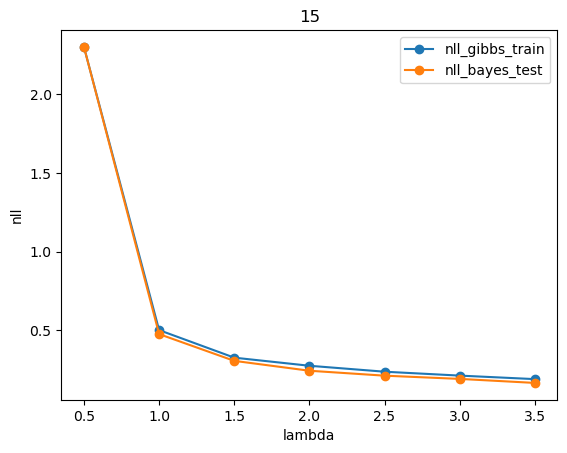

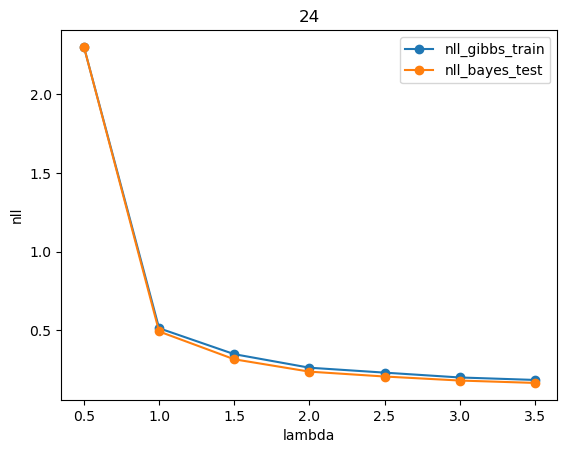

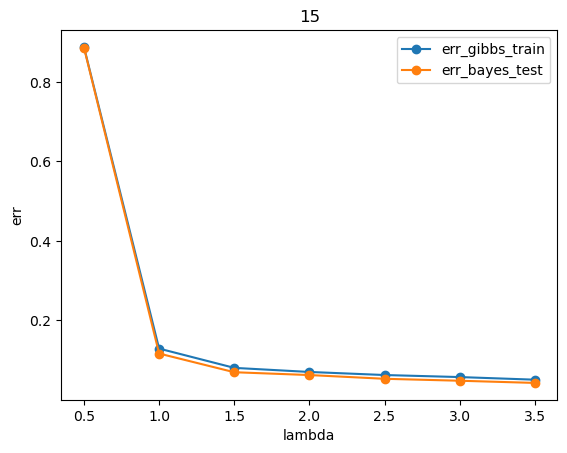

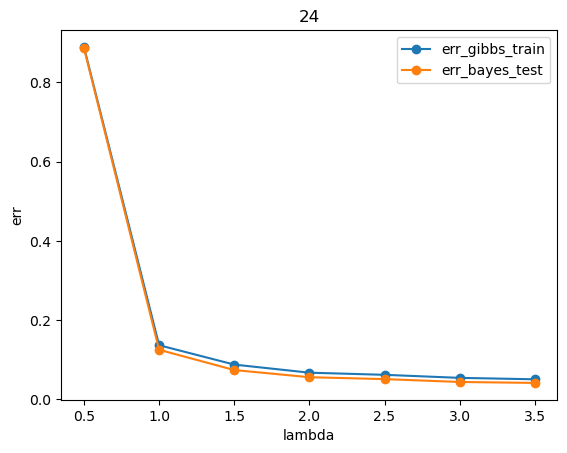

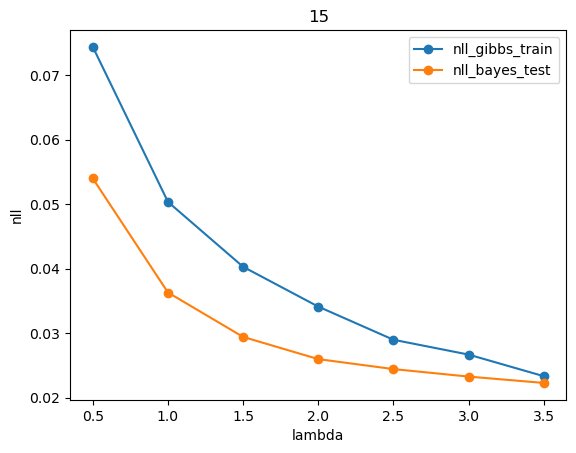

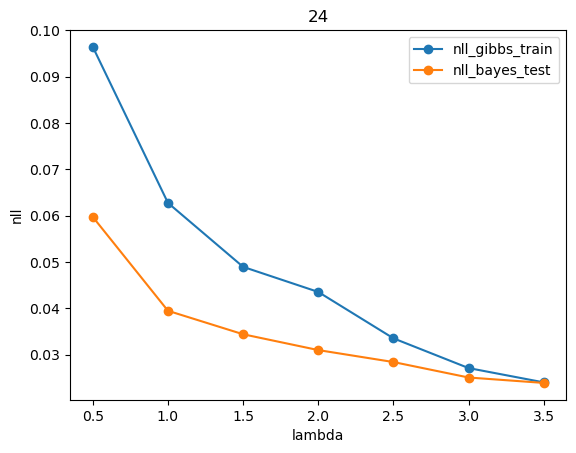

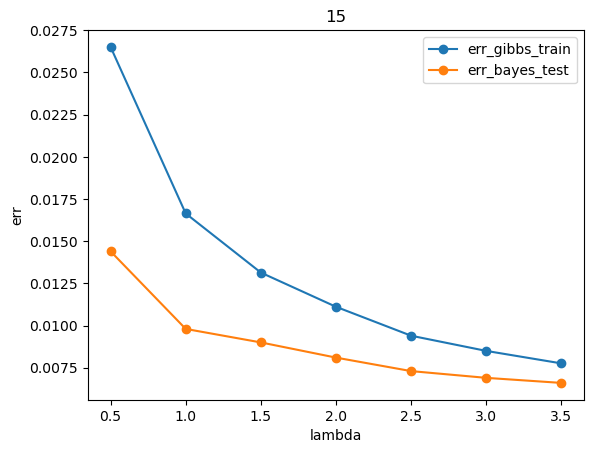

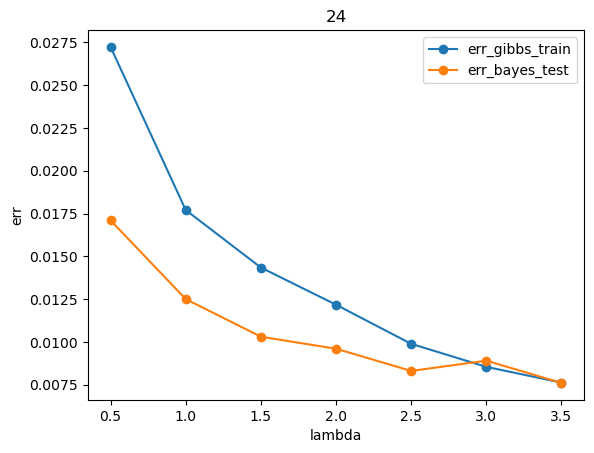

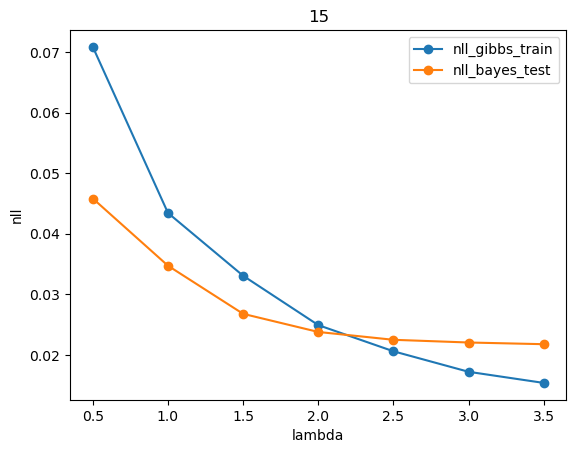

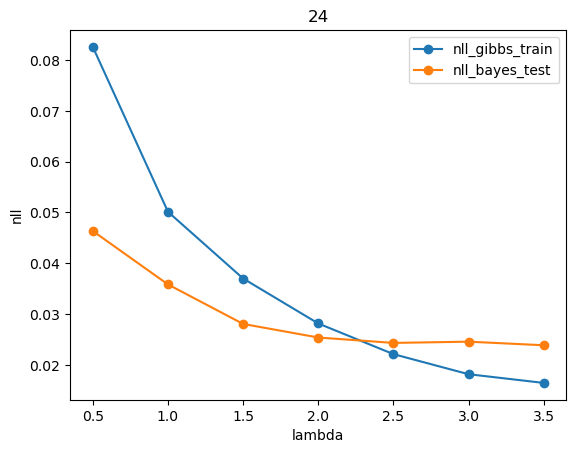

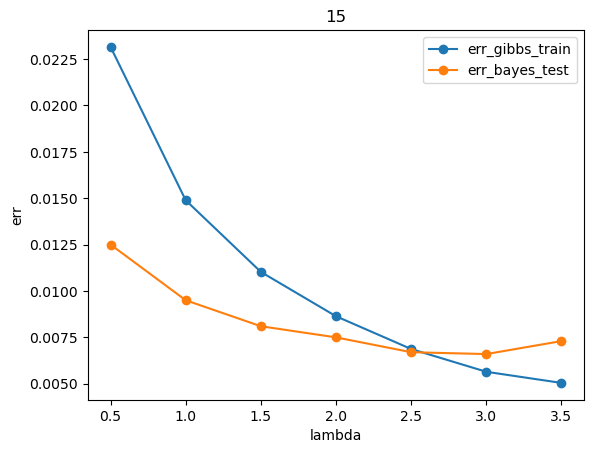

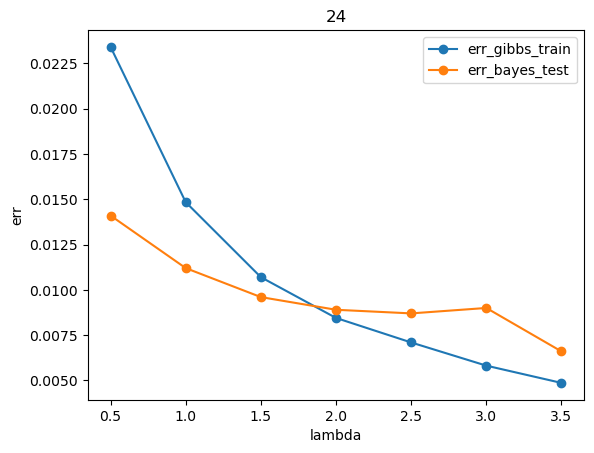

In [60]:
all_metrics = {}
for prior_scale in [0.01, 0.1, 1.0]:
    setting_i = f"prior_scale_{prior_scale}_label_noise_0.0_smooth_softmax_1.0_data_augmentation_False"

    with open(f"{setting_i}.pickle", "rb") as handle:
        results = pickle.load(handle)
    metrics = get_metrics(results)
    seeds = list(results.keys())
    cpe_weights = list(results[seeds[0]].keys())
    # cpe_weights.remove("setting")

    all_metrics[prior_scale] = metrics

    dir_prefix = f"./main/{setting_i}/"
    if not os.path.exists(dir_prefix):
        os.makedirs(dir_prefix)

    name_metrics = ["nll", "err"]
    for metric in name_metrics:
        for seed in seeds:
            save_name = f"main_{metric}_{seed}"
            plt.title(f"{seed}")
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_gibbs_train"],
                marker="o",
                label=f"{metric}_gibbs_train",
            )
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_bayes_test"],
                marker="o",
                label=f"{metric}_bayes_test",
            )
            # plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
            plt.xticks(np.arange(0, len(cpe_weights), 1), cpe_weights)
            plt.xlabel("lambda")
            plt.ylabel(f"{metric}")
            # plt.ylim(0,0.5)
            plt.legend()
            plt.savefig(f"{dir_prefix}/{save_name}.png", dpi=300)
            plt.show()


In [61]:
name_metric = "err_bayes_test"
name_seed = 24
df = pd.DataFrame()
for prior_scale in [0.01, 0.1, 1.0]:
    this_df = pd.DataFrame.from_dict(all_metrics[prior_scale][name_seed])[name_metric]
    this_df.rename(prior_scale, inplace=True)
    df = pd.concat([df, this_df], axis=1)
df.index = list(np.linspace(0.5, 3.5, 7))


In [62]:
df


,0.01,0.10,1.00
0.5,0.8865,0.0171,0.0141
1.0,0.1249,0.0125,0.0112
1.5,0.0737,0.0103,0.0096
2.0,0.0556,0.0096,0.0089
2.5,0.0508,0.0083,0.0087
3.0,0.0436,0.0089,0.0090
3.5,0.0412,0.0076,0.0066


## label noise

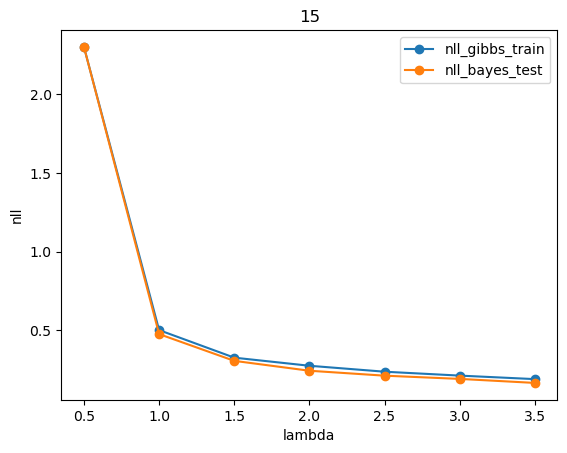

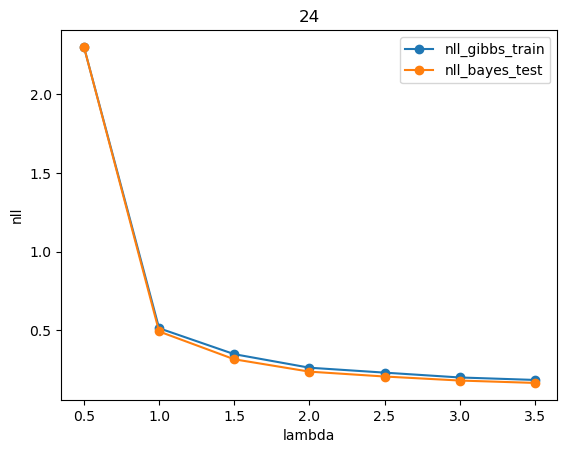

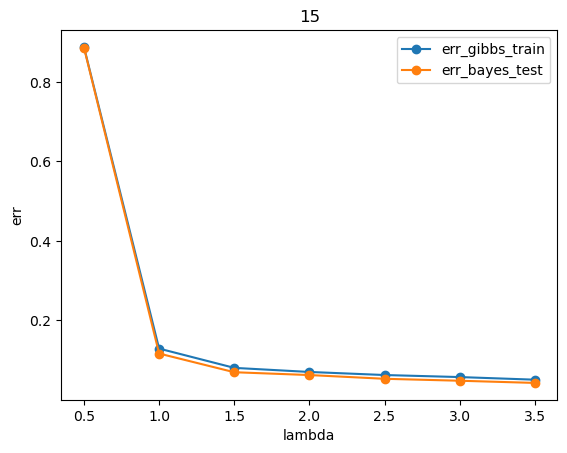

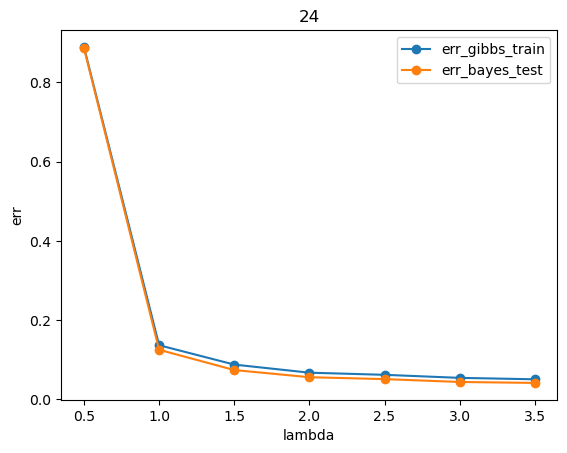

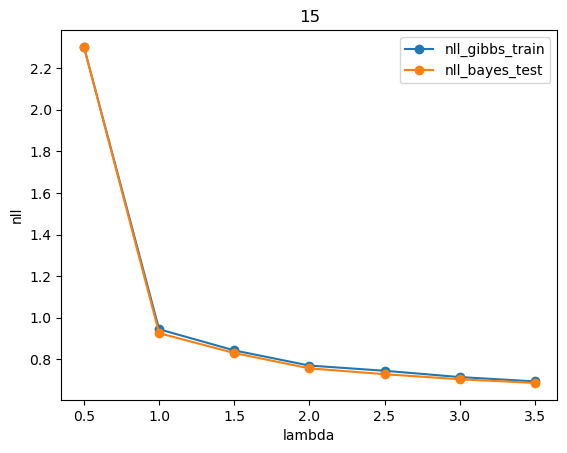

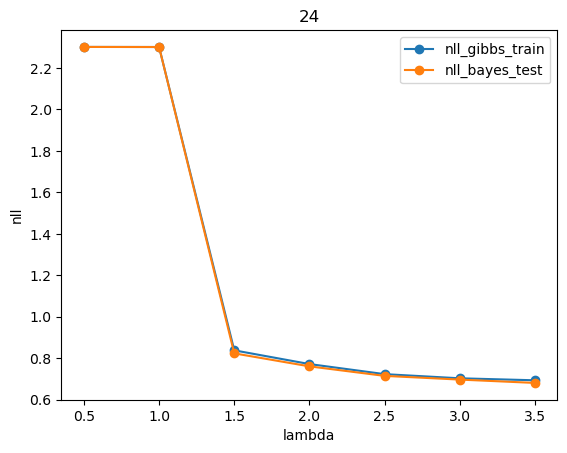

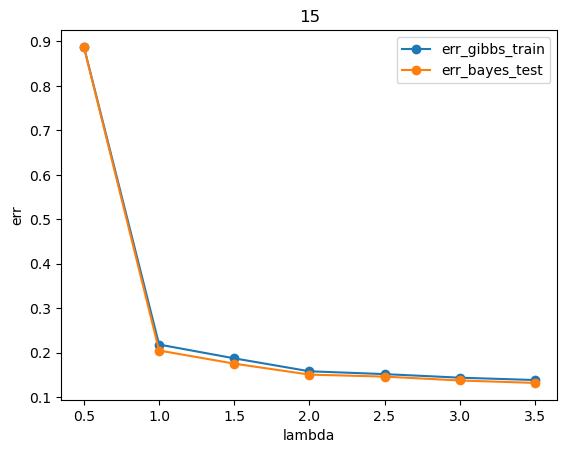

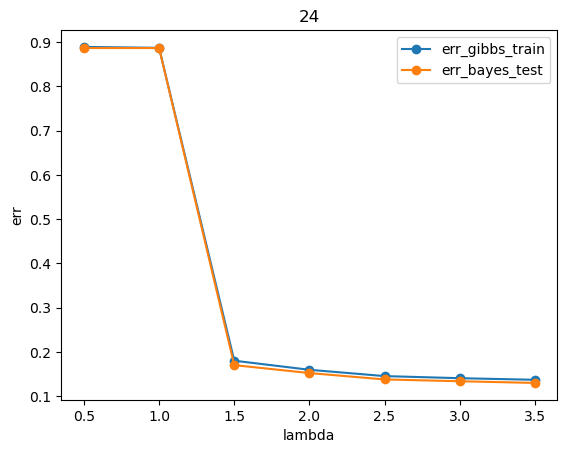

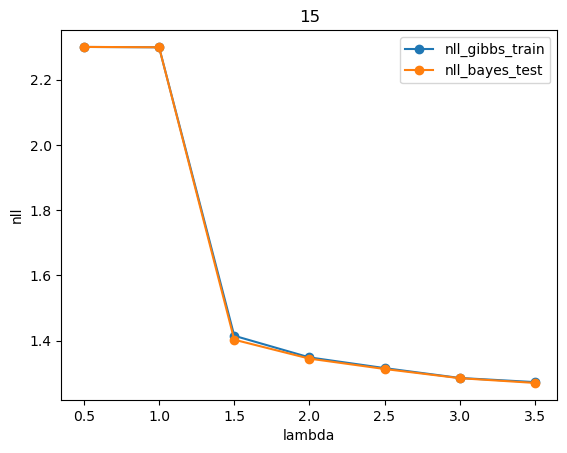

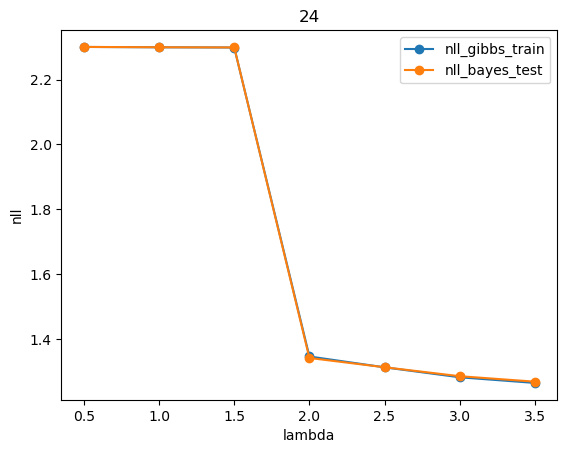

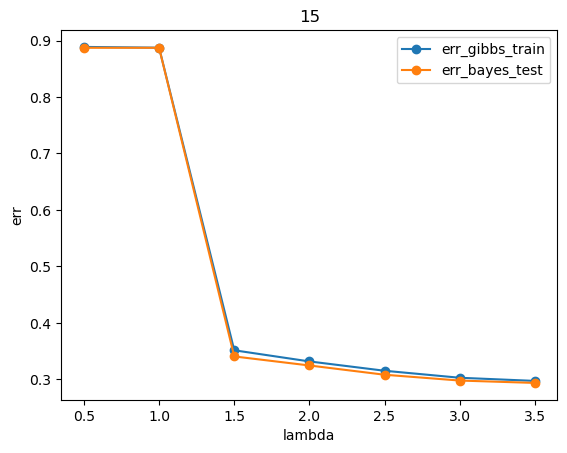

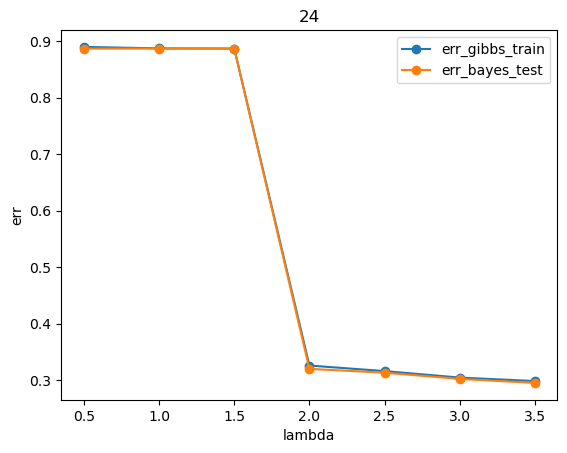

In [63]:
all_metrics = {}
for label_noise in [0.0, 0.1, 0.2]:
    setting_i = f"prior_scale_0.01_label_noise_{label_noise}_smooth_softmax_1.0_data_augmentation_False"

    with open(f"{setting_i}.pickle", "rb") as handle:
        results = pickle.load(handle)
    metrics = get_metrics(results)
    seeds = list(results.keys())
    cpe_weights = list(results[seeds[0]].keys())
    # cpe_weights.remove("setting")

    all_metrics[label_noise] = metrics

    dir_prefix = f"./main/{setting_i}/"
    if not os.path.exists(dir_prefix):
        os.makedirs(dir_prefix)

    name_metrics = ["nll", "err"]
    for metric in name_metrics:
        for seed in seeds:
            save_name = f"main_{metric}_{seed}"
            plt.title(f"{seed}")
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_gibbs_train"],
                marker="o",
                label=f"{metric}_gibbs_train",
            )
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_bayes_test"],
                marker="o",
                label=f"{metric}_bayes_test",
            )
            # plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
            plt.xticks(np.arange(0, len(cpe_weights), 1), cpe_weights)
            plt.xlabel("lambda")
            plt.ylabel(f"{metric}")
            # plt.ylim(0,0.5)
            plt.legend()
            plt.savefig(f"{dir_prefix}/{save_name}.png", dpi=300)
            plt.show()


In [64]:
name_metric = "nll_bayes_test"
name_seed = 24
df = pd.DataFrame()
for label_noise in [0.0, 0.1, 0.2]:
    this_df = pd.DataFrame.from_dict(all_metrics[label_noise][name_seed])[name_metric]
    this_df.rename(label_noise, inplace=True)
    df = pd.concat([df, this_df], axis=1)
df.index = list(np.linspace(0.5, 3.5, 7))


In [65]:
df


,0.0,0.1,0.2
0.5,2.301938,2.301750,2.300560
1.0,0.492622,2.301353,2.299532
1.5,0.315786,0.823026,2.298934
2.0,0.237219,0.760369,1.340986
2.5,0.206292,0.714444,1.312364
3.0,0.180682,0.696535,1.284727
3.5,0.165488,0.680415,1.267840


## smooth softmax

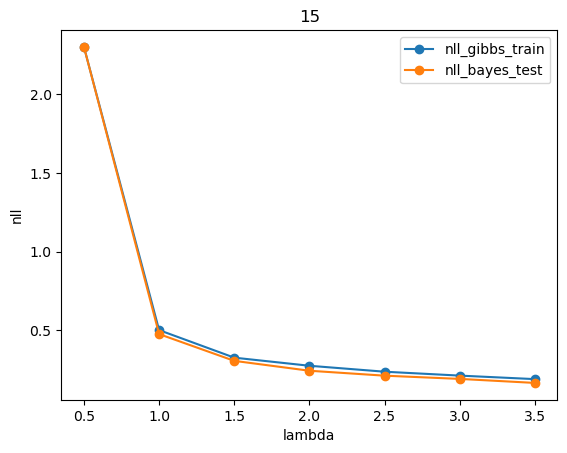

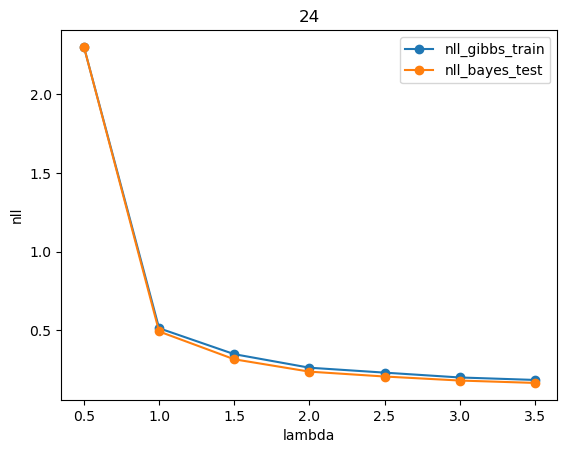

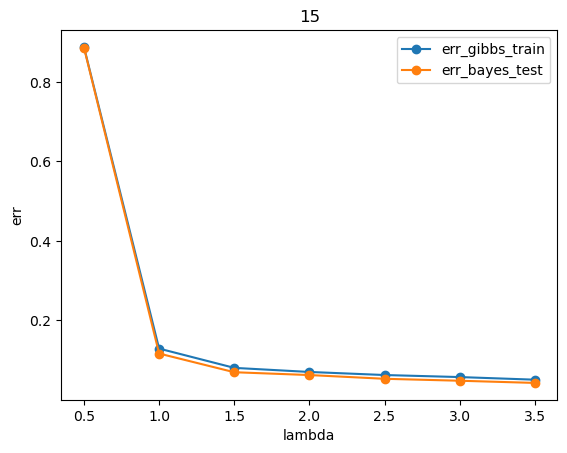

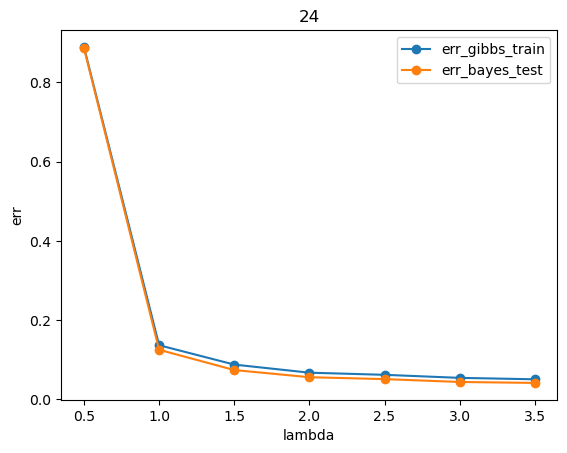

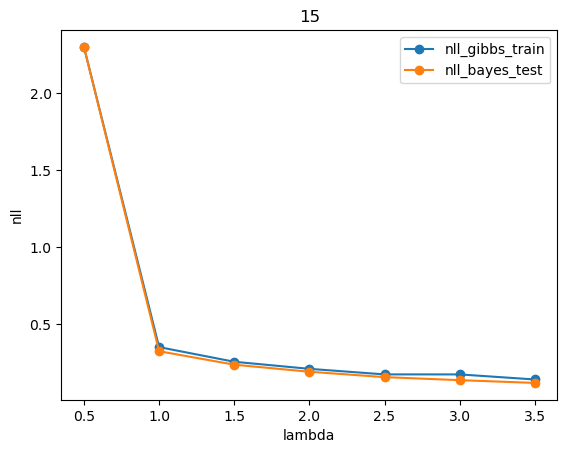

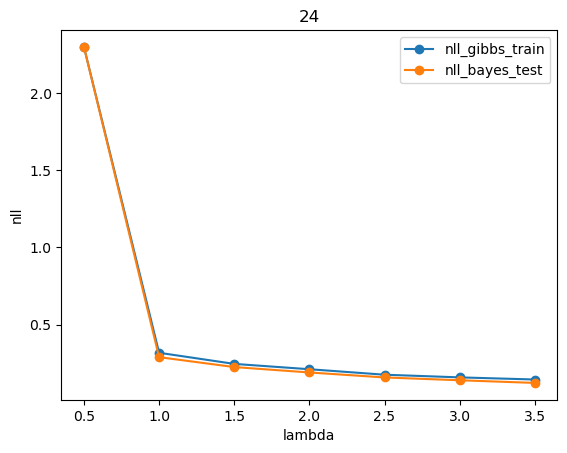

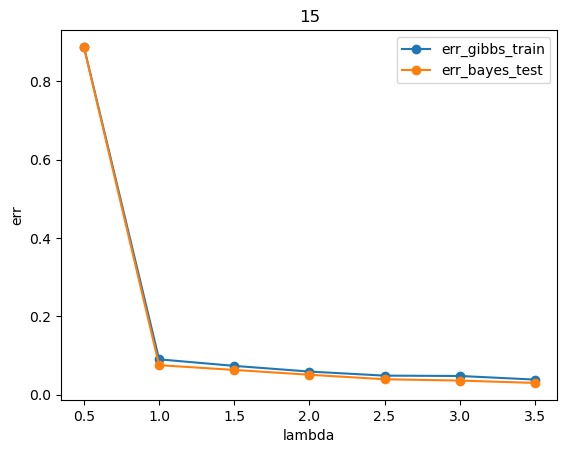

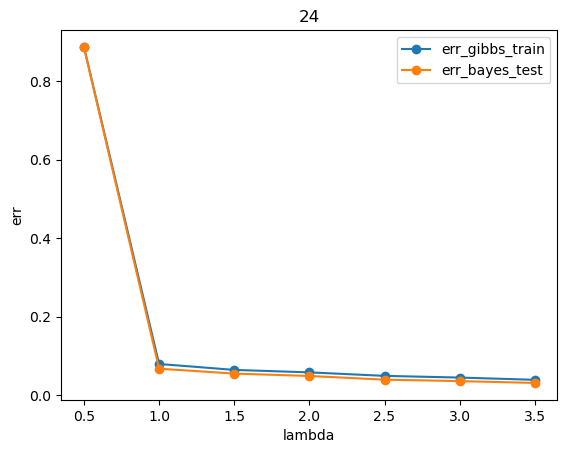

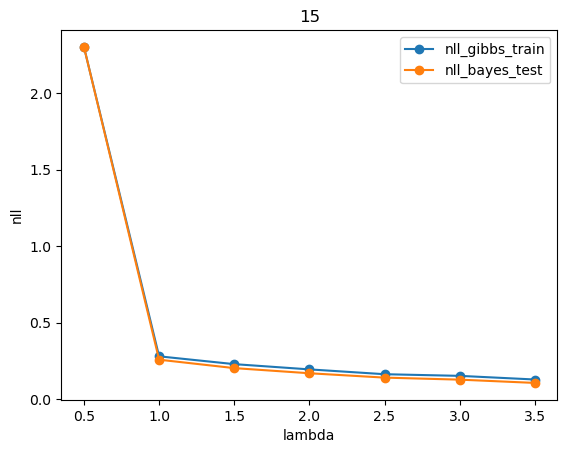

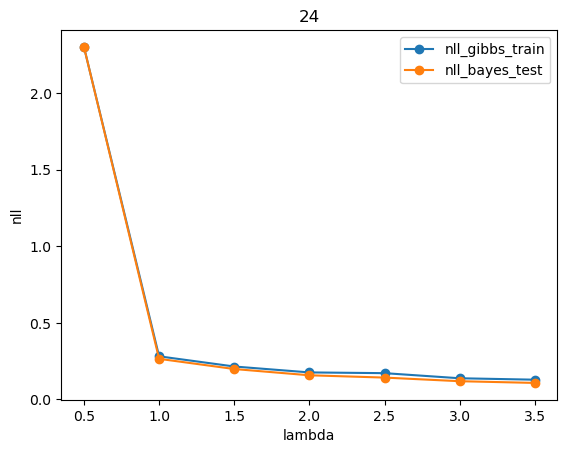

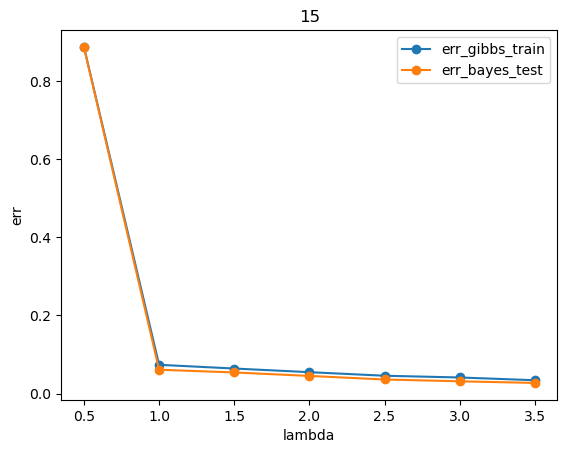

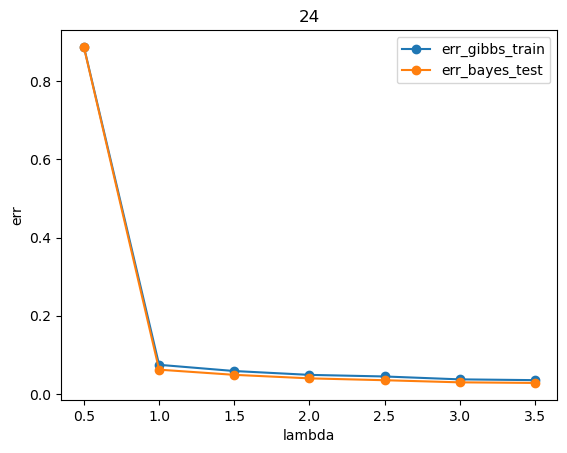

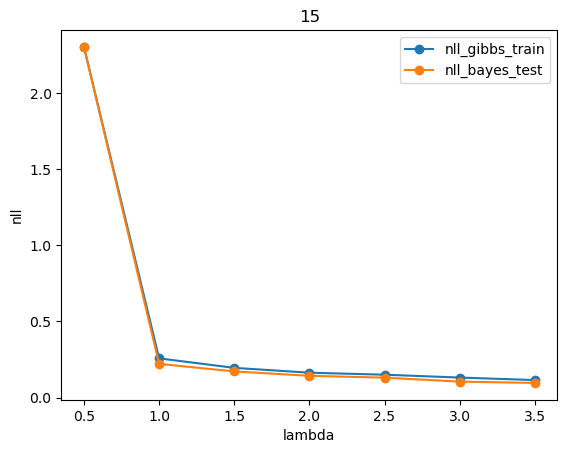

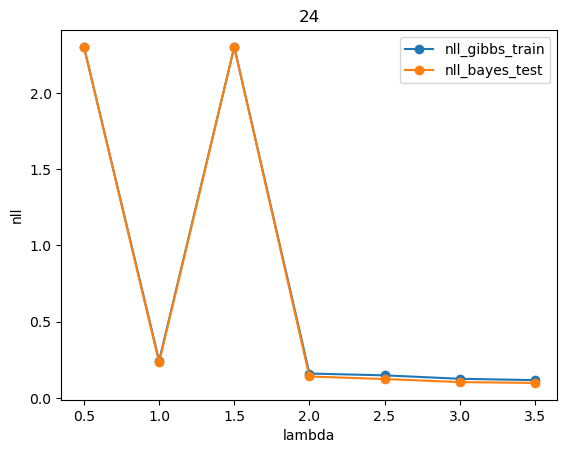

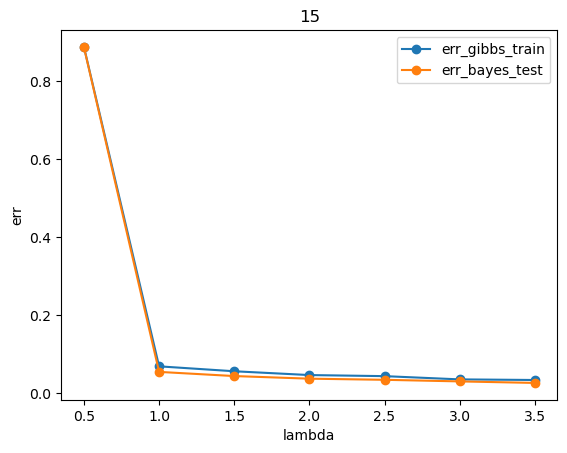

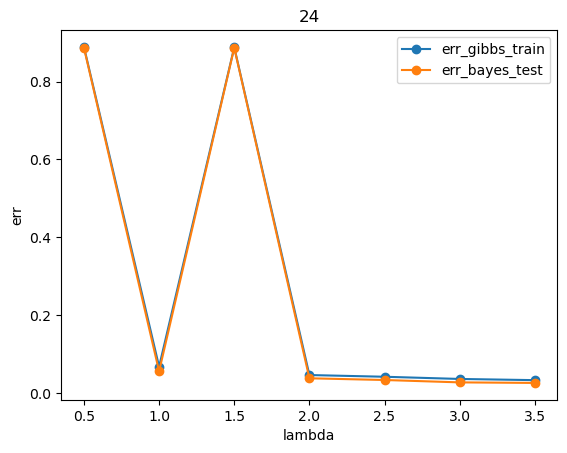

In [66]:
all_metrics = {}
for gamma in [1.0, 3.0, 5.0, 10.0]:
    setting_i = f"prior_scale_0.01_label_noise_0.0_smooth_softmax_{gamma}_data_augmentation_False"

    with open(f"{setting_i}.pickle", "rb") as handle:
        results = pickle.load(handle)
    metrics = get_metrics(results)
    seeds = list(results.keys())
    cpe_weights = list(results[seeds[0]].keys())
    # cpe_weights.remove("setting")

    all_metrics[gamma] = metrics

    dir_prefix = f"./main/{setting_i}/"
    if not os.path.exists(dir_prefix):
        os.makedirs(dir_prefix)

    name_metrics = ["nll", "err"]
    for metric in name_metrics:
        for seed in seeds:
            save_name = f"main_{metric}_{seed}"
            plt.title(f"{seed}")
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_gibbs_train"],
                marker="o",
                label=f"{metric}_gibbs_train",
            )
            plt.plot(
                np.arange(0, len(cpe_weights), 1),
                metrics[seed][f"{metric}_bayes_test"],
                marker="o",
                label=f"{metric}_bayes_test",
            )
            # plt.xticks(np.arange(0,len(cpe_weights),1), np.log10(cpe_weights))
            plt.xticks(np.arange(0, len(cpe_weights), 1), cpe_weights)
            plt.xlabel("lambda")
            plt.ylabel(f"{metric}")
            # plt.ylim(0,0.5)
            plt.legend()
            plt.savefig(f"{dir_prefix}/{save_name}.png", dpi=300)
            plt.show()


In [67]:
name_metric = "nll_bayes_test"
name_seed = 15
df = pd.DataFrame()
for gamma in [1.0, 3.0, 5.0, 10.0]:
    this_df = pd.DataFrame.from_dict(all_metrics[gamma][name_seed])[name_metric]
    this_df.rename(gamma, inplace=True)
    df = pd.concat([df, this_df], axis=1)
df.index = list(np.linspace(0.5, 3.5, 7))


In [68]:
df


,1.0,3.0,5.0,10.0
0.5,2.301915,2.301089,2.300972,2.301090
1.0,0.475579,0.324631,0.257575,0.221518
1.5,0.305317,0.237038,0.202530,0.171986
2.0,0.242495,0.191196,0.168898,0.143277
2.5,0.211100,0.156232,0.140401,0.131198
3.0,0.190525,0.136477,0.127160,0.105046
3.5,0.164981,0.118580,0.105734,0.096574
